<a href="https://colab.research.google.com/github/HungPham2002/image-retrieval-using-pretrained-ViT/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==4.31.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

In [3]:
!unzip /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/image_retrieval_dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: images_mr/5415.jpg      
  inflating: images_mr/5416.jpg      
  inflating: images_mr/5417.jpg      
  inflating: images_mr/5418.jpg      
  inflating: images_mr/5419.jpg      
  inflating: images_mr/542.jpg       
  inflating: images_mr/5420.jpg      
  inflating: images_mr/5421.jpg      
  inflating: images_mr/5422.jpg      
  inflating: images_mr/5423.jpg      
  inflating: images_mr/5424.jpg      
  inflating: images_mr/5425.jpg      
  inflating: images_mr/5426.jpg      
  inflating: images_mr/5427.jpg      
  inflating: images_mr/5428.jpg      
  inflating: images_mr/5429.jpg      
  inflating: images_mr/543.jpg       
  inflating: images_mr/5430.jpg      
  inflating: images_mr/5431.jpg      
  inflating: images_mr/5432.jpg      
  inflating: images_mr/5433.jpg      
  inflating: images_mr/5434.jpg      
  inflating: images_mr/5435.jpg      
  inflating: images_mr/5436.jpg      
  inflating: images_mr/5437.jpg

In [4]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)[:500]
src_images = []
for filename in image_filenames:
  filepath = os.path.join(
      dataset_dir,
      filename
  )
  image = cv2.imread(filepath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  src_images.append(image)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224").to(device)

In [6]:
def preprocessing(images):
  inputs = processor(
      images,
      return_tensors='pt'
  ).to(device)

  with torch.no_grad():
    output = model(
        **inputs,
        output_hidden_states=True
    ).hidden_states[-1][:,0,:].detach().cpu().numpy()

  return output

In [7]:
def mean_absolute_error(query_vector, src_vectors):
  abs_diff = np.abs(src_vectors - query_vector)
  mae = np.neab(abs_diff, axis = 1)

  return mae

def mean_squared_error(query_vector, src_vectors):
  squared_error = (src_vectors - query_vector)**2
  mse = np.mean(squared_error, axis = 1)

  return mse


def cosine_similarity(query_vector, src_vectors):
  query_norm = np.linalg.norm(query_vector)
  normalized_query = query_vector / query_norm
  src_norms = np.linalg.norm(src_vectors, axis=1)
  normalized_src = src_vectors / src_norms[:, np.newaxis]

  cosine_similarity = np.dot(
      normalized_src,
      normalized_query
  )
  return cosine_similarity

def corrlation_coefficient(query_vector, src_vectors):
  corr_coef = np.corrcoef(
      query_vector,
      src_vectors
  )[:-1,-1]
  return corr_coef

In [17]:
def ranking(
    preprocessed_query_image,
    preprocessed_src_images,
    top_k = 10
):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]
    return ranked_list, scores

In [10]:
print(preprocessed_src_images.shape)
print(len(preprocessed_src_images))
print(preprocessed_query_image.shape)

(500, 768)
500
(1, 768)


Query Image


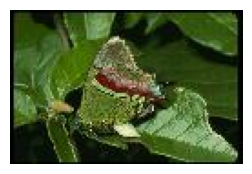

Top 10 results


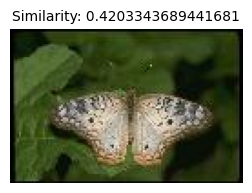

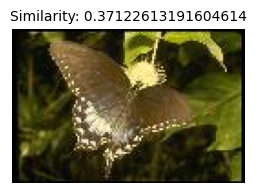

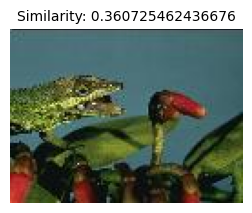

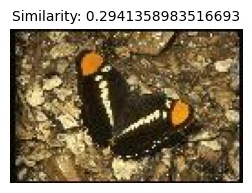

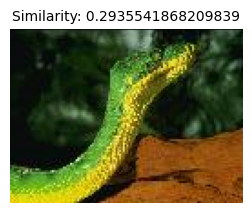

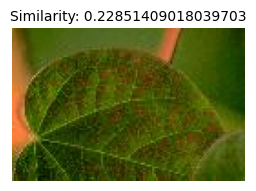

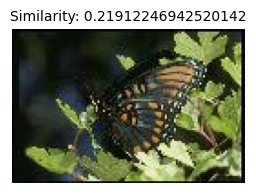

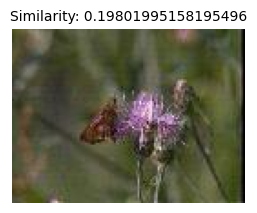

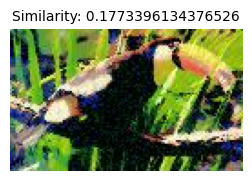

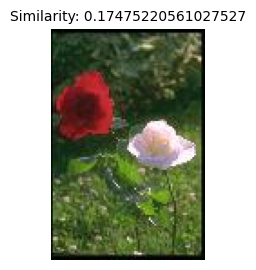

----------------------------------------


In [25]:
query_image_paths = [
    '/content/images_mr/1.jpg'
]
top_k = 10
preprocessed_src_images = preprocessing(src_images)
for query_image_path in query_image_paths:
  query_image = cv2.imread(query_image_path, 1)
  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
  preprocessed_query_image = preprocessing(query_image)
  preprocessed_query_image = np.reshape(preprocessed_query_image, (768,))
  ranked_list, scores = ranking(
      preprocessed_query_image,
      preprocessed_src_images,
      top_k
  )
  print('Query Image')
  plt.figure(figsize=(3,3))
  plt.imshow(query_image)
  plt.axis('off')
  plt.show()

  print(f'Top {top_k} results')
  for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3,3))
    plt.imshow(src_images[src_image_idx])
    plt.title(f'Similarity: {similarity_score}', fontsize=10)
    plt.axis('off')
    plt.show()
  print('----------------------------------------')